[*********************100%***********************]  1 of 1 completed


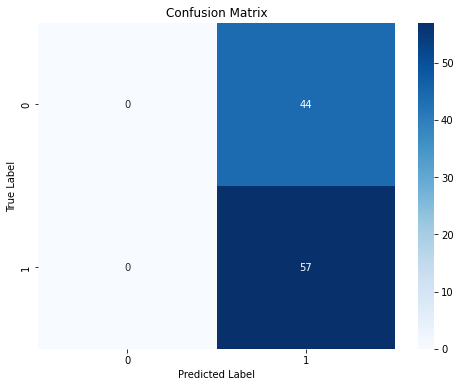

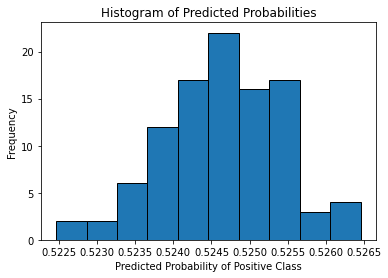

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.56      1.00      0.72        57

    accuracy                           0.56       101
   macro avg       0.28      0.50      0.36       101
weighted avg       0.32      0.56      0.41       101



C:\Users\achin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\achin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\achin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
import yfinance as yf
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

def create_sliding_window(data, window_size):
    X = []
    for i in range(len(data) - window_size+1):
        X.append(data[i: (i + window_size)])
    return np.array(X)

# Download historical data
data = yf.download('AAPL', '2010-01-01', '2023-05-30')
# Calculate the daily returns
data['returns'] = data['Close'].pct_change()

# Drop missing values
data = data.dropna()

# Add a column 'direction' which is our target variable. 1 for positive returns, 0 for negative
data = data.copy()
data.loc[:, 'direction'] = np.where(data['returns'].shift(-1) > 0, 1, 0)
data.to_csv("After direction.csv")
# Prepare data for SVM
x = data['returns'].values  # features
y = data['direction'].values  # target

# Create sliding window of past 30 days
window_size = 30
X = create_sliding_window(x, window_size)

# The target variable needs to be shifted accordingly
y = y[window_size-1:]

# Scale the features
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Create a mask for the data that falls before your cutoff date

# Create a mask for the data that falls before your cutoff date
cutoff_date = pd.to_datetime('2023-01-01')
# Create the index for X based on the last date in each window
X_dates = data.index[window_size - 1:]

# Now create masks for X and y based on these dates
mask_X = X_dates < cutoff_date

# Since y is already shifted, you can use the same mask for it
mask_y = mask_X

# Now split the data into training and test sets using the masks
X_train = X[mask_X]
y_train = y[mask_y]
X_test = X[~mask_X]
y_test = y[~mask_y]



# Train the SVM classifier with GridSearchCV for basic parameter tuning
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svm.SVC(probability=True), parameters)
clf.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = clf.predict(X_test)
# Access the best parameters and best estimator
best_params = clf.best_params_
best_estimator = clf.best_estimator_

# Generate a summary of the model
summary = f"Best Parameters: {best_params}\n"
summary += f"Best Estimator: {best_estimator}\n"
summary += f"Best Score: {clf.best_score_}\n"
summary += f"CV Results: {clf.cv_results_}\n"


# Print a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get predicted probabilities
y_pred_prob = clf.predict_proba(X_test)

# Extract probabilities of the positive class
prob_positive = y_pred_prob[:, 1]

# Create a histogram
plt.hist(prob_positive, bins=10, edgecolor='k')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


# Print a classification report
print(classification_report(y_test, y_pred))

In [2]:
print(summary)

Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Estimator: SVC(C=1, kernel='linear', probability=True)
Best Score: 0.5252934238809945
CV Results: {'mean_fit_time': array([1.03803577, 1.55546207, 1.30923028, 1.9961987 ]), 'std_fit_time': array([0.00657386, 0.01049262, 0.0514988 , 0.01121602]), 'mean_score_time': array([0.03550324, 0.11410961, 0.03514609, 0.1148066 ]), 'std_score_time': array([0.00044705, 0.00135253, 0.00037175, 0.01486926]), 'param_C': masked_array(data=[1, 1, 10, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 1, 'kernel': 'rbf'}, {'C': 10, 'kernel': 'linear'}, {'C': 10, 'kernel': 'rbf'}], 'split0_test_score': array([0.5146379 , 0.5192604 , 0.5146379 , 0.49460709]), 'split1_test_score': array([0.53466